# MLP 311


In [47]:
NC_FILENAME='ncRNA.gc34.unprocessed.fasta'
PC_FILENAME='pcRNA.gc34.unprocessed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP311'
NEURONS=16

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [49]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [50]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [51]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [52]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [53]:
def make_frequencies(Xin):
    Xout=[]
    #VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            # Here is a quick & dirty way to avoid counting K-mers with N (val=0)
            if kmerval > 0:
              freqs[kmerval] += 1
              total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [54]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [55]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y


Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP311.model/assets
Data prep


In [56]:
import scipy.stats as ss
PSEUDOCOUNT=0.000001
def make_zscores(Xin):
    Xout=[]
    #VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        counts =[0] * VOCABULARY_SIZE
        for kmerval in seq:
            # Here is a quick & dirty way to avoid counting K-mers with N (val=0)
            if kmerval > 0:
              counts[kmerval] += 1
        pcounts=[x+PSEUDOCOUNT for x in counts]   # avoid divide by zero in numpy log
        lcounts = np.log(pcounts) 
        zcounts = ss.zscore(lcounts)
        Xout.append(zcounts)
    Xnum = np.asarray(Xout)
    return (Xnum)


In [57]:
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
print("after make_kmers:",X_train)
print(X_train.shape)
#X_train=make_frequencies(X_train)
X_train=make_zscores(X_train)
print("after make_zscores:",X_train)
print(X_train.shape)


Data reshape
after make_kmers: [[47 58 37 ...  0  0  0]
 [53 20 14 ...  0  0  0]
 [43 43 44 ...  0  0  0]
 ...
 [13 49  1 ...  0  0  0]
 [15 58 38 ...  0  0  0]
 [15 57 36 ...  0  0  0]]
(60792, 1000)
after make_zscores: [[-7.6172191  -0.08672123  0.05208517 ...  0.2477218   0.20573887
   0.1089154 ]
 [-7.63950556  0.37714647  0.28747954 ...  0.03625219  0.48688992
   0.62837384]
 [-7.45348192  0.35469175 -0.30936641 ...  0.35469175  0.16046717
   0.35469175]
 ...
 [-3.40467697  0.50998698  0.43309757 ...  0.36363786  0.19628021
   0.43309757]
 [-3.81291398  0.10119631  0.3483909  ...  0.10119631  0.21058165
   0.21058165]
 [-2.31778145  0.22018815  0.22018815 ...  0.41236607  0.65486765
   0.66200856]]
(60792, 65)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4854 - accuracy: 0.7662 - val_loss: 0.4605 - val_accuracy: 0.7799
Epoch 2/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4580 - accuracy: 0.7833 - val_loss: 0.4454 - val_accuracy: 0.7873
Epoch 3/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4487 - accuracy: 0.7888 - val_loss: 0.4486 - val_accuracy: 0.7880
Epoch 4/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4437 - accuracy: 0.7918 - val_loss: 0.4438 - val_accuracy: 0.7877
Epoch 5/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4409 - accuracy: 0.7936 - val_loss: 0.4357 - val_accuracy: 0.7903
Epoch 6/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4382 - accuracy: 0.7955 - val_loss: 0.4379 - val_accuracy: 0.7910
Epoch 7/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4353 - a

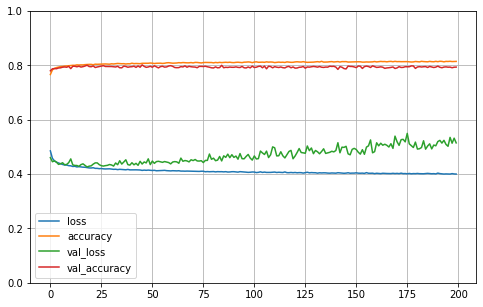

accuracy: 80.18%
COMPILE...
...COMPILED
FIT
Epoch 1/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4863 - accuracy: 0.7674 - val_loss: 0.4657 - val_accuracy: 0.7748
Epoch 2/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4578 - accuracy: 0.7829 - val_loss: 0.4451 - val_accuracy: 0.7913
Epoch 3/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4485 - accuracy: 0.7904 - val_loss: 0.4568 - val_accuracy: 0.7811
Epoch 4/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4438 - accuracy: 0.7921 - val_loss: 0.4452 - val_accuracy: 0.7900
Epoch 5/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4396 - accuracy: 0.7952 - val_loss: 0.4359 - val_accuracy: 0.7931
Epoch 6/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4371 - accuracy: 0.7942 - val_loss: 0.4313 - val_accuracy: 0.7957
Epoch 7/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4349 - 

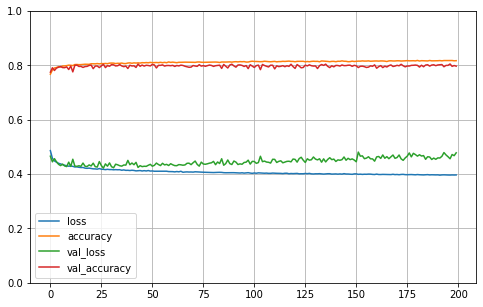

accuracy: 80.51%
COMPILE...
...COMPILED
FIT
Epoch 1/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4849 - accuracy: 0.7645 - val_loss: 0.4645 - val_accuracy: 0.7816
Epoch 2/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4574 - accuracy: 0.7836 - val_loss: 0.4551 - val_accuracy: 0.7857
Epoch 3/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4494 - accuracy: 0.7899 - val_loss: 0.4502 - val_accuracy: 0.7839
Epoch 4/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4440 - accuracy: 0.7906 - val_loss: 0.4434 - val_accuracy: 0.7959
Epoch 5/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4399 - accuracy: 0.7930 - val_loss: 0.4411 - val_accuracy: 0.8018
Epoch 6/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4381 - accuracy: 0.7952 - val_loss: 0.4456 - val_accuracy: 0.7962
Epoch 7/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4345 - 

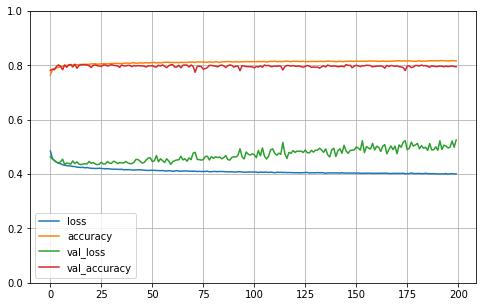

accuracy: 80.46%
COMPILE...
...COMPILED
FIT
Epoch 1/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4871 - accuracy: 0.7653 - val_loss: 0.4551 - val_accuracy: 0.7849
Epoch 2/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4569 - accuracy: 0.7836 - val_loss: 0.4559 - val_accuracy: 0.7908
Epoch 3/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4470 - accuracy: 0.7886 - val_loss: 0.4465 - val_accuracy: 0.7862
Epoch 4/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4407 - accuracy: 0.7926 - val_loss: 0.4339 - val_accuracy: 0.7939
Epoch 5/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4374 - accuracy: 0.7929 - val_loss: 0.4320 - val_accuracy: 0.7998
Epoch 6/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4346 - accuracy: 0.7961 - val_loss: 0.4326 - val_accuracy: 0.7974
Epoch 7/200
1710/1710 [==============================] - 4s 3ms/step - loss: 0.4318 - 

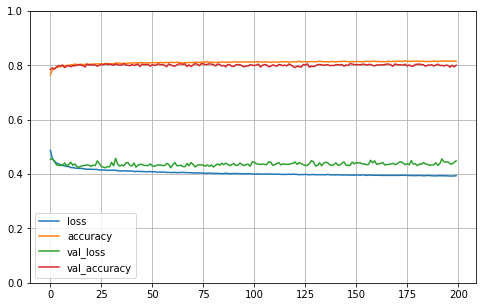

accuracy: 80.66%
COMPILE...
...COMPILED
FIT
Epoch 1/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4867 - accuracy: 0.7659 - val_loss: 0.4641 - val_accuracy: 0.7748
Epoch 2/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4578 - accuracy: 0.7828 - val_loss: 0.4595 - val_accuracy: 0.7900
Epoch 3/200
1710/1710 [==============================] - 5s 3ms/step - loss: 0.4495 - accuracy: 0.7867 - val_loss: 0.4500 - val_accuracy: 0.7933
Epoch 4/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4429 - accuracy: 0.7916 - val_loss: 0.4449 - val_accuracy: 0.7905
Epoch 5/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4397 - accuracy: 0.7931 - val_loss: 0.4499 - val_accuracy: 0.7883
Epoch 6/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4355 - accuracy: 0.7967 - val_loss: 0.4490 - val_accuracy: 0.7931
Epoch 7/200
1710/1710 [==============================] - 4s 2ms/step - loss: 0.4324 - 

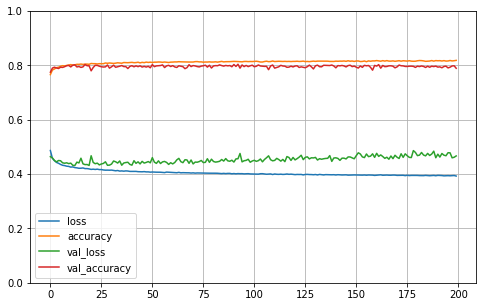

accuracy: 80.41%

5-way Cross Validation mean 80.44% (+/- 0.16%)
Done


In [58]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")